## load your data

In [1]:
use "~/Data/Dropbox/Working_Directory/Python/Stat_models/VAR/new_keynesian.dta", clear

## clear your memory

In [2]:
program drop _all

## install a package that automatically set up nice tables in stata

In [3]:
ssc install estout

checking estout consistency and verifying not already installed...
all files already exist and are up to date.


## check your data

In [4]:
describe


Contains data from ~/Data/Dropbox/Working_Directory/Python/Stat_models/VAR/new_k
> eynesian.dta
  obs:           238                          
 vars:             4                          22 Oct 2019 17:03
 size:         6,664                          
--------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
--------------------------------------------------------------------------------
quarter         float   %tq                   quarter
infl            double  %14.2f                inflation (% wrt same quarter last
                                                year)
unemp           double  %14.2f                unemployment rate (%)
intrate         double  %14.2f                effective federal funds rate (%)
--------------------------------------------------------------------------------
Sorted by: quarter


In [5]:
list quarter in 1
list quarter in -1



     +---------+
     | quarter |
     |---------|
  1. |  1960q1 |
     +---------+


     +---------+
     | quarter |
     |---------|
238. |  2019q2 |
     +---------+


## first of all, let's hope that seasonal differences are stationary:

In [6]:
dfuller s4.infl


Dickey-Fuller test for unit root                   Number of obs   =       233

                               ---------- Interpolated Dickey-Fuller ---------
                  Test         1% Critical       5% Critical      10% Critical
               Statistic           Value             Value             Value
------------------------------------------------------------------------------
 Z(t)             -4.760            -3.466            -2.881            -2.571
------------------------------------------------------------------------------
MacKinnon approximate p-value for Z(t) = 0.0001


In [7]:
dfuller s4.unemp


Dickey-Fuller test for unit root                   Number of obs   =       233

                               ---------- Interpolated Dickey-Fuller ---------
                  Test         1% Critical       5% Critical      10% Critical
               Statistic           Value             Value             Value
------------------------------------------------------------------------------
 Z(t)             -3.583            -3.466            -2.881            -2.571
------------------------------------------------------------------------------
MacKinnon approximate p-value for Z(t) = 0.0061


In [8]:
dfuller s4.intrate


Dickey-Fuller test for unit root                   Number of obs   =       233

                               ---------- Interpolated Dickey-Fuller ---------
                  Test         1% Critical       5% Critical      10% Critical
               Statistic           Value             Value             Value
------------------------------------------------------------------------------
 Z(t)             -4.809            -3.466            -2.881            -2.571
------------------------------------------------------------------------------
MacKinnon approximate p-value for Z(t) = 0.0001


## all fine. actually, what do these series look like?

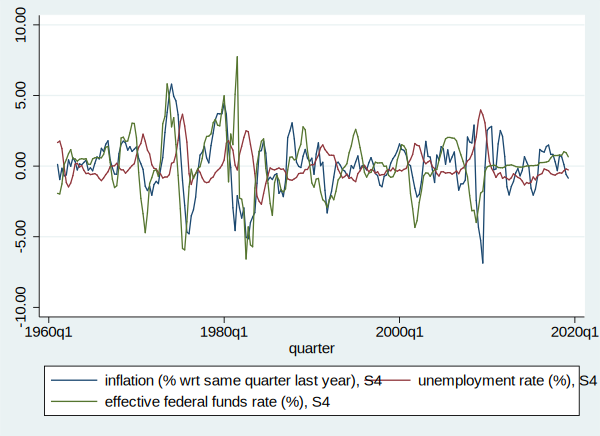

In [9]:
tsline s4.infl s4.unemp s4.intrate

## there does appear to be some comovement, especially between the two financial series, so it makes sense to consider VARs

### to fully satisfy my OCD, I am writing it into a function with for-loop

In [10]:
capture program drop var_est
program define var_est

    forvalues i = 1(1)`1' {
    
        display 
        display "-------------------------------------------"
        display "computing VAR with `i' lag terms "
        display "-------------------------------------------"
        display
        
        var s4.infl s4.unemp s4.intrate, lags(1/`i')
        
        estimates store m`i', title(max lag:`i')
        
        scalar BIC_model_lag_`i' = e(sbic)
    }
    
    display 
    display "-------------------------------------------"
    display "computing BIC of each model"
    display "-------------------------------------------"
    display

    scalar list
end

In [11]:
var_est 5


-------------------------------------------
computing VAR with 1 lag terms 
-------------------------------------------


Vector autoregression

Sample:  1961q2 - 2019q2                        Number of obs     =        233
Log likelihood =  -771.4124                     AIC               =    6.72457
FPE            =   .1671187                     HQIC              =   6.796241
Det(Sigma_ml)  =   .1507601                     SBIC              =   6.902306

Equation           Parms      RMSE     R-sq      chi2     P>chi2
----------------------------------------------------------------
S4_infl               4      1.0247   0.7109   572.8341   0.0000
S4_unemp              4     .416048   0.8410   1232.134   0.0000
S4_intrate            4     1.12649   0.6941   528.5837   0.0000
----------------------------------------------------------------

------------------------------------------------------------------------------
             |      Coef.   Std. Err.      z    P>|z|     [95% Conf

## let's convert them into a table easy for comparison

* **each column represents a model with different max lag terms**
* **in each row, the slope coefficient and two-tail p-value is listed for each model**

In [12]:
estout m1 m2 m3 m4, cells(b(fmt(2)) p(fmt(2))) ///
	legend label varlabels(_cons constant) ///
	stats(r2 sbic N)


------------------------------------------------------------------------
                        max lag:1    max lag:2    max lag:3    max lag:4
                              b/p          b/p          b/p          b/p
------------------------------------------------------------------------
S4_infl                                                                 
LS4.inflation (% w~a         0.71         0.98         0.94         0.90
                             0.00         0.00         0.00         0.00
L2S4.inflation (% ~a                     -0.28        -0.14        -0.18
                                          0.00         0.14         0.05
L3S4.inflation (% ~a                                  -0.18         0.07
                                                       0.01         0.46
L4S4.inflation (% ~a                                               -0.23
                                                                    0.00
LS4.unemployment r~)        -0.20        -0.45    

## if you are fond of typing stata commands repetitively, do the following commands

In [13]:
* var s4.infl s4.unemp s4.intrate, lags(1/1)
* var s4.infl s4.unemp s4.intrate, lags(1/2)
* var s4.infl s4.unemp s4.intrate, lags(1/3)
* var s4.infl s4.unemp s4.intrate, lags(1/4)
* var s4.infl s4.unemp s4.intrate, lags(1/5)

## the models just keep getting better, in terms of BIC... but this is starting to feel ridiculously overparameterised. since lag 4 is meaningful here (quarterly data), maybe we can use only lags 1 and 4?

In [14]:
var s4.infl s4.unemp s4.intrate, lags(1 4)


Vector autoregression

Sample:  1962q1 - 2019q2                        Number of obs     =        230
Log likelihood =  -698.5888                     AIC               =   6.257294
FPE            =   .1047393                     HQIC              =    6.38392
Det(Sigma_ml)  =   .0872528                     SBIC              =   6.571206

Equation           Parms      RMSE     R-sq      chi2     P>chi2
----------------------------------------------------------------
S4_infl               7      .93223   0.7666   755.2364   0.0000
S4_unemp              7     .365739   0.8779   1653.775   0.0000
S4_intrate            7     1.07422   0.7275   614.0765   0.0000
----------------------------------------------------------------

------------------------------------------------------------------------------
             |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
S4_infl      |
        infl |
 

## not quite, we do need more. in an AR model I would go with a multiplicative lagstructure, but that isn't really a thing for VARs. since p=P=1 would model lags 1, 4, and 5, let's see what happens if we estimate an unrestricted VAR with those lags:

In [15]:
var s4.infl s4.unemp s4.intrate, lags(1 4 5)


Vector autoregression

Sample:  1962q2 - 2019q2                        Number of obs     =        229
Log likelihood =  -627.0452                     AIC               =   5.738386
FPE            =   .0623446                     HQIC              =    5.91986
Det(Sigma_ml)  =   .0479664                     SBIC              =   6.188219

Equation           Parms      RMSE     R-sq      chi2     P>chi2
----------------------------------------------------------------
S4_infl              10     .848913   0.8098   974.9697   0.0000
S4_unemp             10     .322878   0.9061   2208.935   0.0000
S4_intrate           10     1.01989   0.7587   720.1443   0.0000
----------------------------------------------------------------

------------------------------------------------------------------------------
             |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
S4_infl      |
        infl |
 

## that looks pretty good. many significant coefficients, and in terms of BIC onlythe huge VAR(6) model was better. let's stick with this one. is everything stable?


   Eigenvalue stability condition
  +----------------------------------------+
  |        Eigenvalue        |   Modulus   |
  |--------------------------+-------------|
  |   .8800193 +  .1405976i  |    .89118   |
  |   .8800193 -  .1405976i  |    .89118   |
  |   .6590692 +   .584684i  |   .881038   |
  |   .6590692 -   .584684i  |   .881038   |
  |   -.599652 +  .6105852i  |   .855802   |
  |   -.599652 -  .6105852i  |   .855802   |
  |   .6957504 +  .4810649i  |   .845868   |
  |   .6957504 -  .4810649i  |   .845868   |
  |  -.5633117 +  .6146028i  |   .833701   |
  |  -.5633117 -  .6146028i  |   .833701   |
  |  -.5752687 +  .5677957i  |   .808286   |
  |  -.5752687 -  .5677957i  |   .808286   |
  |   .5658301 +  .5002645i  |   .755267   |
  |   .5658301 -  .5002645i  |   .755267   |
  |   .7508951               |   .750895   |
  +----------------------------------------+
   All the eigenvalues lie inside the unit circle.
   VAR satisfies stability condition.


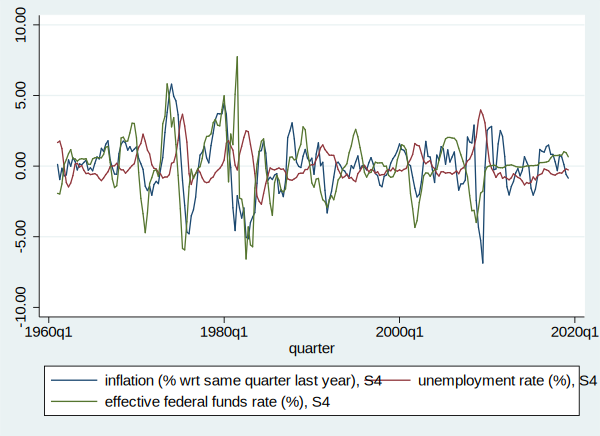

In [16]:
varstable

## cool. stationary, but pretty persistent (modulus not very far below one), and mostly complex eigenvalues (so we get cyclical behaviour). what do Granger causality tests look like?

In [17]:
vargranger


   Granger causality Wald tests
  +------------------------------------------------------------------+
  |          Equation           Excluded |   chi2     df Prob > chi2 |
  |--------------------------------------+---------------------------|
  |           S4_infl           S4.unemp |   7.005     3    0.072    |
  |           S4_infl         S4.intrate |  15.124     3    0.002    |
  |           S4_infl                ALL |  36.895     6    0.000    |
  |--------------------------------------+---------------------------|
  |          S4_unemp            S4.infl |  6.8737     3    0.076    |
  |          S4_unemp         S4.intrate |  8.3599     3    0.039    |
  |          S4_unemp                ALL |  35.483     6    0.000    |
  |--------------------------------------+---------------------------|
  |        S4_intrate            S4.infl |   .5548     3    0.907    |
  |        S4_intrate           S4.unemp |  12.917     3    0.005    |
  |        S4_intrate                ALL |  

## interesting. very different result from the model in class, with regular instead of seasonal differences. inflation shocks do not pass through to anything else; inflation and unemployment do respond to monetary policy; and monetary policyis partly driven by unemployment shocks, but not by inflation shocks. seems quite reasonable, from an economic point of view. what's the impact on our forecasts?

In [18]:
tsappend, add(47)
fcast compute pred_, step(47)

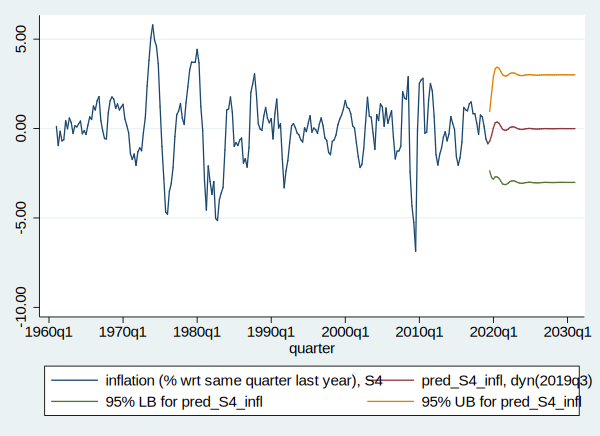

In [19]:
tsline s4.infl pred_S4_infl pred_S4_infl_LB pred_S4_infl_UB

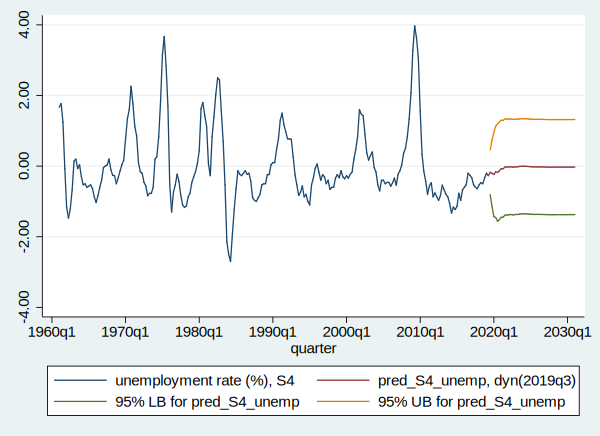

In [20]:
tsline s4.unemp pred_S4_unemp pred_S4_unemp_LB pred_S4_unemp_UB

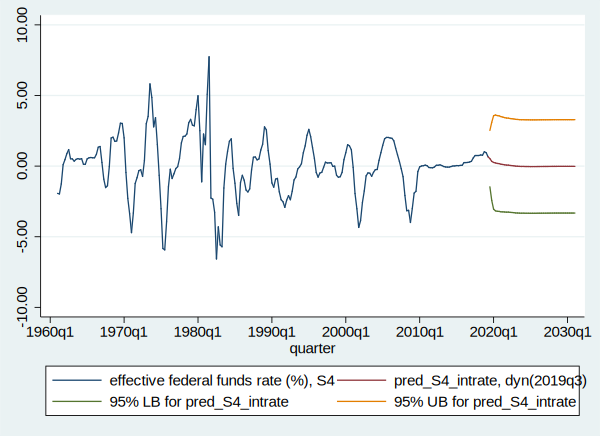

In [21]:
tsline s4.intrate pred_S4_intrate pred_S4_intrate_LB pred_S4_intrate_UB

## still quick mean-reversion, but not as fast as before. also, more interesting seasonal patterns show up now that we're actually modelling them, particularly for inflation. so I guess those should also show up in the IRFs:

In [22]:
irf create irfvar, step(12) set(irfvar)

(file irfvar.irf created)
(file irfvar.irf now active)
(file irfvar.irf updated)


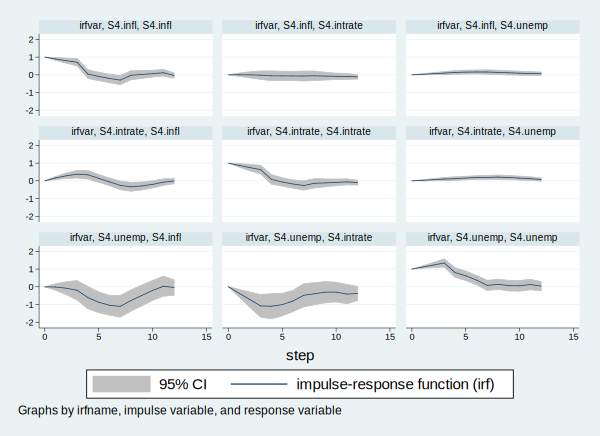

In [23]:
irf graph irf

## a bit more seasonal than before... but qualitatively, not all that different. in particular, monetary policy is still statistically significant but economically probably insignificant